In [6]:
# In this file, we verify the conditions in Proposition 4.2 and Lemma 4.9
# See Appendix B for meaning of some variables and instructions. 
# Press Run All to run the code and verify the estimates 

# p, d parameters,  l = 4 / (p-1) + 1, ga short for gamma 
# Num, number of comptuered series
l, ga = var('l ga')
d = 4
Num = 10

# Parameters in Section 2.1 
ep = l * ga**2 - 1
A = d + 1 - (d - 1 - 2 * l) * ga
B = 2 * d - 1 - l 

# (U, Y) ODE system defined in Section 2.2 
# fy(Y) is the same as f(Y) in the paper, and it is not the derivative
fy(Y) = - ep - A * Y + B * Y**2
del_U(Y, U) = 2 * U * ( U + fy(Y) + (d-1) * Y * (1 - Y) )
del_Y(Y, U) = ( - 1 + d * Y ) * U + ( Y-1) * fy(Y) 

# The map from (Y, U) to (Z, V) defined in Section 2.2 
Z_map(Y, U) = ( U + (1- Y)**2 )**(1/2) / (  1 / (ga + 1) * U + 1 - Y )


# U(Y) = U_DelY(Y), U_DelU is the root of  del_Y(Y, U) = 0, del_U(Y, U) = 0, defined in Section 2.3 
U_DelU(Y) = - ( fy(Y) + (d-1) * Y * (1 - Y) )
U_DelY(Y) = - ( Y-1) * fy(Y)  / ( - 1 + d * Y )

# Ug, root of del_Z(Y, U) = 0 in Section 2.3 
Ug(Y) = l * ( Y + ga)**2 - (1 - Y)**2

# C_infty, V1, V3 derivatives defined in Lemma 4.8
V1 = (d-1) / d / (ga + 1)
V3 = 1 / (d + 2) * (   (d-1) * ( - 2 / (ga + 1) * V1**2 + V1**3 + V1**2 ) \
    + V1 * ( 2 * V1 + l * (V1 - 1)**2 )    )
C_infty = - (ga + 1)^3 * (V3 - V1**2 + V1**3)

Yo = 1 / d 

# degU = dU, degY = dY in Section 2.2 in the paper, which are degree of del_a as polynomials in U, a = Y, U.
# The following output is symbolic, we need to manully change to integer
degU = 2
degY = 1

# (Y0, U0) sonic point at the (Y, U) system 
Y0 = 0
U0 = ep 

# The gradient of del_U, del_Y at the spnic point defined in Section 2.4 
c1 = del_U.diff(U)(Y = Y0, U = U0).full_simplify()
c3 = del_U.diff(Y)(Y = Y0, U = U0).full_simplify()

c2 = del_Y.diff(U)(Y = Y0, U = U0).full_simplify()
c4 = del_Y.diff(Y)(Y = Y0, U = U0).full_simplify()

# U1 = d U / d Y at the sonic point, lam_neg = \lambda_-, and U1 are defined in Section 2.4 
lam_neg = ( (c1 + c4) - ( (c1 - c4)**2 + 4 * c2 * c3 ) **(1/2) ) / 2
U1 =  ( lam_neg - c4 ) / c2 

# Create a power series placeholder for U, range include 0,1.., Num;
x = var("x")
UU = list(var('U_%d' % i) for i in (0..Num))

# PP, save the polynomials in the coefficients 
FF = list(var('F_%d' % i) for i in (0..2))
GG = list(var('G_%d' % i) for i in (0..2))

# Define Basic operation for power series expansion 
# Power_prod get power series of A * B up to n terms, following Section 3.1 
# len(A) - 1, len(B) - 1 are the upper bound of degree of polynomials A, B
def Power_prod(n, A, B):
    C = list(var('C_%d' % i) for i in (0..n))
    for i in (0..n):
        C[i] = sum( A[i-j] * B[j] for j in (max(i+1-len(A), 0)..min(len(B)-1,i)  ) )
    return C 

# return power series coefficients of c1 * A + c2 * B up to n terms 
def Power_sum(n, A, B, c1, c2):
    C = list(var('C_%d' % i) for i in (0..n))
    for i in (0..n):
        C[i] = 0
        if i <= len(A)-1: 
            C[i] = C[i] + c1 * A[i]    
        if i <= len(B)-1: 
            C[i] = C[i] + B[i] * c2
            
    return C 

# First compute the Powerseries expansion of del_U, del_Y in U. See Section 2.2 
# del_U = sum_i F_i(Y) * U^i, del_Y = sum_i G_i(Y) * U^i. FF[i] denote F_i, GG[i] denote G_i
# d_U (del_U) = sum_i F_i(Y) * i * U^{i-1},  d_U(del_Y) = sum_i G_i(Y) * i * U^{i-1}

# Then compute the power series coefficients DelUn, DelYn of del_U(Y, U(Y)), del_Y(Y, U(Y)) in Y
# Input n, we only compute the first n power series coefficients 
def Power_Del(n):
    # Given power series of U : UU[0], UU[1],... as symbolic value
    # U_pow[i] store power series coefficients for U^i. U^0 = 1. 
    U_pow = [ [1], UU]
    deg = max(degU, degY)
    U_now = UU 
    for i in (2.. deg) :
        U_next = Power_prod(n, U_now, UU)
        U_pow.append( U_next) 
        U_now = U_next 
    
    # Get the coeffiicents as polynomial in xi = Y -  Y0 
    xi = var('xi')

    for i in (0..deg):
        if i <= degU:                      
            # Derive the coefficients of U^i in del_U, and then expand the Y polynoamils as xi, for Y = Y0 + xi
            ff0(Y) = ( (del_U(Y, U).diff(U, i) / factorial(i))(U =0) ).full_simplify()    
            FF[i] = ff0(Y = xi + Y0).list(xi)   
    
        if i <= degY:
            # Do the same for del_Y 
            gg0(Y) = ( (del_Y(Y, U).diff(U, i) / factorial(i))(U =0) ).full_simplify()  
            GG[i] = gg0(Y = xi+ Y0).list(xi)

        # Assemble the power series for del_U=  sum_i F_i(Y) * U^i, and  del_Y,
        # Initialize with the first summand
        if i == 0 :
            # vanishes at the sonic point 
            DelUn = FF[0]
            DelYn = GG[0]
        else: 
            # add the expansion from F_i(Y) * U^i to DelUn, and G_i(Y) * U^i to DelYn
            if i <= degU :        
                DelUn = Power_sum(n, DelUn, Power_prod(n, FF[i], U_pow[i] ), 1, 1 )

            if i<= degY :
                DelYn = Power_sum(n, DelYn, Power_prod(n, GG[i], U_pow[i] ), 1, 1 )
        
    return DelUn, DelYn 

DelUn, DelYn = Power_Del(Num)

In [7]:
# Below, we compute the power series coefficients of U
# Set the precision for the interval arithmetic. 
prec = 200 

# We use X_V to denote the interval arithmetic value for X. X_R for floating point value 
# X_R default value type for X 
RR = RealBallField(prec)
l_R = 5/3 
l_V = RR(l_R)

# coe(i) for the coefficient of U_i in the recursive formula in Lemma 3.2
coe(i) = i * (c2 * U1 + c4) + c2 * U1 - c1 

# DelUn, DelYn are coefficients of the power series expansion of del_U, del_Y
# Compute the power series coefficients of U following Lemma 3.2 
def solu(ga_V, I_show):
    solu = {ga : ga_V , l:l_V}

    # First assemble the first two coefficients for U_i, Delta_{U, i}, Delta_{Y,i}, i=0,1
    DUn = [RR(0)]
    DYn = [RR(0)]

    U1_V = RR( U1(solu))

    solu[UU[0]] = RR( U0(solu))
    solu[UU[1]] = U1_V 
    DUn.append(RR(DelUn[1]( solu)))
    DYn.append(RR(DelYn[1]( solu)))

    if I_show == 1:
        print("U0: ", solu[UU[0]])
        print("U1: ", solu[UU[1]])

    solu1 = solu 

    c1_V = c1(solu)
    c2_V = c2(solu)

    for i in (2.. Num):

        # In solu1, at step i, we have value for U_0, .., U_{i-1}, but U_i = 0.
        # We use this to evaluate the right hand side of the recursive formula.
        # DUn0, DYn0 evaluate the mathring part 
        solu1[UU[i]] = 0
        
        DUn0 = RR(DelUn[i](solu1))
        DYn0 = RR(DelYn[i](solu1))

        # Evaluating DYn[j], 2 \leq j \leq i-1, we do not need value of U[i].
        M = RR(sum( (i+1-j) * DYn[j] *  solu[UU[i+1-j]] for j in (2..i-1) ))
        
        solu[UU[i]] = RR( (DUn0 - U1_V * DYn0 - M ) / ( RR(coe(i)(solu) ) ) )
        # With UU[i], update the value of DUn, DYn for (del_U)_i, (del_Y)_i using formulas in Lemma 3.2 
        DUn.append( DUn0 + c1_V *  solu[UU[i]])
        DYn.append( DYn0 + c2_V *  solu[UU[i]])

        if I_show == 1: 
            # Show that U_i / U_{i-1} grow linearly. 
            print("U_i / U_{i-1} - U_{i-1}/U_{i-2}:" + str(i) +": ", \
            solu[UU[i]] / solu[UU[i-1]] -  solu[UU[i-1]] /solu[UU[i-2]] )
                    
        # solu1 stores computed value of U[0],.,U[i]
        solu1 = solu 

    return solu, DUn, DYn 

# I_show = 0 not present the value
solu0 = solu(RR(l_V**(-1/2)) , 0)[0]



In [8]:
# Get the min and max of a polynomial over [a, b]
# Follow the method at the end of Appendix B 
RR_poly.<t> = PolynomialRing(RR)

def Poly_bound( P, a, b, h):
    # Obtain upper and lower bound of P(t) for t in [a, b];  0<= a < b 
    coe = P.list(t)
    lenP = len(coe)-1

    # Do not the case with a < 0 or b < 0. Otherwise, raise error 
    if a < 0 or b < 0: 
        raise ValueError("a, b must be nonnegative !")

    # P = P_pos - P_neg, both parts are monotone 
    P_pos = RR_poly( [max(coe[i], 0) for i in (0..lenP)])
    P_neg = RR_poly( [max(-coe[i], 0) for i in (0..lenP)])

    # t0 .., tN 
    m = floor( float( (b-a) / h)) + 1
    ti = [a + i * h  for i in (0..m) ]
    ti[-1] = b 
    
    P_pos_V = [P_pos(ti[i] ) for i in (0.. m)]
    P_neg_V = [P_neg(ti[i] ) for i in (0.. m)]

    P_up = max( [ max( P_pos_V[i], P_pos_V[i+1] ) - min( P_neg_V[i], P_neg_V[i+1] ) for i in (0..m-1)] )
    P_low = min( [ min( P_pos_V[i], P_pos_V[i+1] ) - max( P_neg_V[i], P_neg_V[i+1] ) for i in (0..m-1)] )

    return P_up, P_low


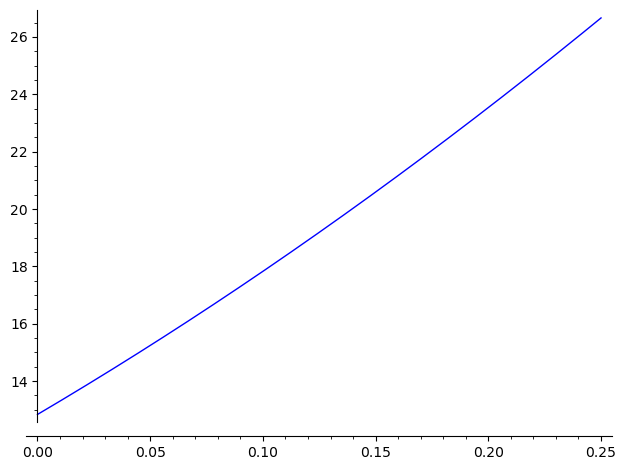

True: Inequality (e) in Prop 4.2: Upper barrier condition holds with normalized lower bound 12.8366481624527


In [9]:
# Construct the upper barrier B_u^f above Q_s in Section 4.1, 
# and Verify Ineq (e) in Proposition 4.2
# X_R default value type in Sage for X. 

def Bar_global_up(solu_R):
    Y0_R = 0
    e1, e2, t = var('e1 e2 t')

    bar_up = e1 + e2 * t + 2 * t ** 2 
    bar_para_up = {e1: U0, e2: U1 }    

    # dif define d_t B(t) * Delta_Y - Delta_U   on Y = t, U = B(t)
    # For t near 0, dif_up = O(t^2). See first few formulas in Section 4.1
    dif_up = bar_up.diff(t) * del_Y(Y=t, U=bar_up) - del_U(Y=t, U=bar_up)
    dif_up_norm = ( dif_up(bar_para_up)  / t^2 ).full_simplify()

    dif_up_norm_V = dif_up_norm(solu_R)
    bar_para_up = {e1: U0(solu_R), e2: U1(solu_R) }
    # We want to show dif_up > 0. Plot the normalized curve for an illustration 
    plot( dif_up_norm_V, (t, 0, 0.25)).show() 
    return dif_up_norm_V, dif_up, bar_up, bar_para_up

ga_V =  RR(l_V)^(-1/2) 

solu_V = {ga: ga_V, l: l_V }
dif_up_norm, dif_up, bar_up, bar_para_up = Bar_global_up(solu_V)

# Verify dif_up_norm > 0, 5-th Inequality for B_u^f in Proposition 4.1 
Flag_up, Flag_low  = Poly_bound( dif_up_norm, 0, RR(1 / d), RR(0.001))

if Flag_low > 0:
    print("True: Inequality (e) in Prop 4.2: Upper barrier condition holds with normalized lower bound", n(Flag_low))
else:
    print("False: Inequality (e) in Prop 4.2:Upper barrier condtion fails" )




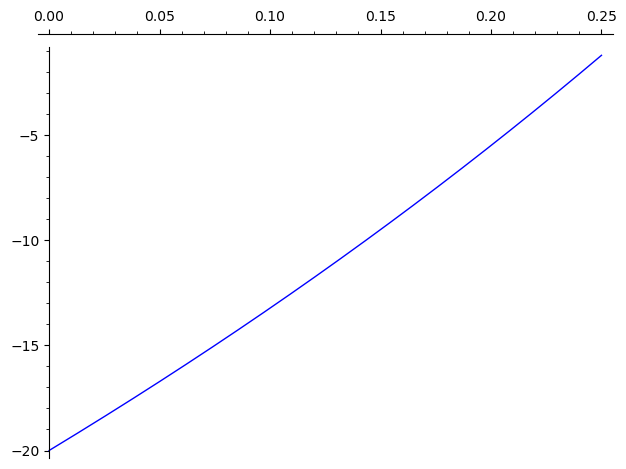

True: Lemma 4.9 Correct
bar_asym: -0.128825736159154 C_infty -0.122652048637932
True: Inequality (d) in Prop 4.2: Lower barrier condition holds with negative upper bound -1.22162663383746


In [10]:
# Construct the global lower barrier B_l^f above Q_s in Section 4.1, 
# Then Verify Ineq (d) in Proposition 4.2 and Lemma 4.9 
# X_R default value type in Sage for X. 

def Bar_global_low(solu_R): 
    Y0_R = 0

    t = var('t')
    e1, e2 = var('e1 e2')

    # Lower bar_low
    bar_low = ( e1 * t + e2 * t**2 - U0 ) / ( d * t - 1)

    # differ define  d_Y B(t) * Delta_Y - Delta_U   on the barrier function Y = t, U = B(t)
    # Want to impose two conditions, d_t bar_low(Y0) = U1, and d_t^2 differ(0) = -40
    # See formula of e1 at the beginning of Section 4.1 
    e1_V = d * U0 - U1 
                
    differ = bar_low.diff(t) * del_Y(Y=t, U=bar_low)  - del_U(Y=t, U=bar_low) 
    differ = differ.full_simplify()

    differ_tt0 = differ.diff(t, 2)(t=0).full_simplify() 

    solu_e2 = solve( [differ_tt0(e1 = e1_V) == -40 ], [e2] )
    bar_para_low0 = {e1: e1_V, e2: solu_e2[0].rhs() }
    
    # For t near 0, differ = O(t^2). See first few formulas in Section 4.1
    # differ_pol =differ * (1 - d t)^2  vanishes O(t^2) near t = 0
    differ_pol = ( ( bar_low.diff(t) * del_Y(Y=t, U=bar_low) \
         - del_U(Y=t, U=bar_low) )* (1 - d * t)**2 ).full_simplify() 

    # By definition, dc0 = 0, dc1 = 0. We subtract these value symbolically 
    dc0 = differ_pol(t=0)
    dc1 = differ_pol.diff(t,1)(t=0)

    differ_norm =  ( (differ_pol - dc0 - dc1 * t) / t^2 ).full_simplify()    
    
    bar_para_low = {e1: e1_V(solu_R), e2: solu_e2[0].rhs()(solu_R) }
    differ_norm = differ_norm(bar_para_low)(solu_R)
    
    # We want to show differ_norm < 0. Plot the normalized curve for an illustration 
    plot(differ_norm, (t, 0, 0.25)).show()

    # Check asymptotics of B_l^f and verify Lemma 4.9. See Section 4.4 
    #( bar_low ~ bar_asym / (t - Yo) as t -> Yo = 1/d 
    bar_asym =  (bar_low * ( t - 1 / d )) .full_simplify()
    bar_asym = bar_asym(bar_para_low)(t= Yo)(solu_R) 

    # The asymptotics of (Y, U(Y)) near Yo = 1 / d : U = C_infty / (Y - Yo) + l.o.t.
    comp = bar_asym - C_infty(solu_R)
    if comp < 0:
        print('True: Lemma 4.9 Correct')
        print('bar_asym:', n(bar_asym), 'C_infty', n(C_infty(solu_R)))
    else:
        print('False: Lemma 4.9 Wrong')

    return bar_low,  bar_para_low, differ_norm, bar_para_low0

bar_low, bar_para_low, differ_norm, bar_para_low0 = Bar_global_low(solu_V)

# Verify diff_norm < 0, 4-th Inequality (d) for B_l^f in Proposition 4.2 
Flag_up, Flag_low = Poly_bound( differ_norm, 0, 1 / RR(d), RR(0.001))

if Flag_up < 0:
    print("True: Inequality (d) in Prop 4.2: Lower barrier condition holds with negative upper bound", n(Flag_up))
else:
    print("False: Inequality (d) in Prop 4.2: Lower barrier condtion fails" )



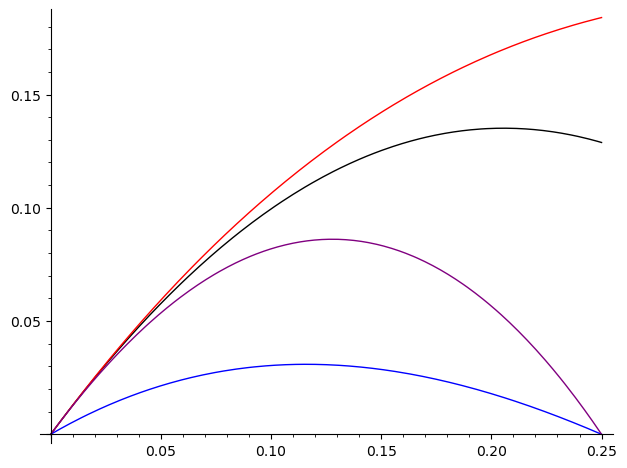

In [11]:
# Plot Relative position of the curve of U_{Delta_Y} (red), bar_low (black),
# bar_up (purple), U_{Delta_U} (blue)
# We multiply by 1 / d - t to avoid inifty at t = 1 / d
# NOT for rigorous proof. Just for illustration of relative positions 

def plot_curve_pos(solu_R, bar_up, bar_low, bar_para_up, bar_para_low, desingu, t_E) :

    if desingu == 1:
        fac =  1 / d - t 
    else:
        fac = 1

    plot2 = plot(  U_DelY(Y=t)(solu_R)  * fac  , (t, 0, t_E), color = 'red' )
    plot1 = plot(  bar_low(bar_para_low) * fac , (t, 0, t_E), color = 'black' )
    plot4 = plot(  bar_up(bar_para_up) * fac, (t, 0, t_E), color = 'purple' )
    plot3 = plot(  U_DelU(Y=t)(solu_R)  * fac  , (t, 0, t_E), color = 'blue' )

    return plot1 + plot2 + plot3  + plot4 

plot_curve_pos(solu_V, bar_up, bar_low(solu_V), bar_para_up, bar_para_low, 1, 0.25) 




In [12]:
# We verify Ineq (a), (b), (c), 6-th and 7-th inequalities in Proposition 4.2

# Verify Ineq (a) 
B_l_dd2 = bar_low(solu_V)(bar_para_low).diff(t, 2)(t=0)
B_u_dd2 = bar_up(bar_para_up).diff(t, 2)(t=0)
U_dd2 = solu0[UU[2]]

if B_u_dd2 < U_dd2 and U_dd2 < B_l_dd2:
    print("True: Inequality (a) in Prop 4.2 for second derivatives at Y0 = 0 are verified with values:", [n(B_u_dd2) , n(U_dd2), n(B_l_dd2) ]  ) 
else:
    print("False: Prop 4.2 is wrong")

# Verify 6-th inequality in Prop 4.2:
# d_Y U(0) - d_Y U_{\Delta_U}(0) > c > 0,    d_Y U(0) - d_Y Ug(0) > c > 0 ,    d_Y U(0) > c > 0
dd1 = solu0[UU[1]] - U_DelU.diff(Y, 1)(Y=0)(solu0)
dd2 = solu0[UU[1]] - Ug.diff(Y, 1)(Y=0)(solu0)
dd3 = solu0[UU[1]] 

if dd1 > 0 and dd2 > 0 and dd3 > 0: 
    print("True: 6 th-Inequality in Prop 4.2 for first derivatives at Y0 = 0 are verified with difference", [n(dd1), n(dd2), n(dd3)] ) 
else:
    print("False: Prop 4.2 is wrong")

# Verify 7-th inequality in Prop 4.2: d Z(Y, U(Y)) / d Y < 0
dd3 = Z_map(Y, U = U0 + U1 * Y).diff(Y, 1)(Y=0)(solu0)
if dd3 < 0 :
    print("True: 7 th-Inequality in Prop 4.2 for the derivative of Z map at Y0 = 0 are verified with value", n(dd3) ) 
else:
    print("False: Prop 4.2 is wrong")


# For Ineuq (b), Ineq (c): Verify relative positions amoong the barrier B_l^f, B_u^f and roots U_{Delta_*}(Y).
# Ineq (c), diff1 > 0: Verify  U_Del_U(Y) < B_u^f(Y). Two functions agree up to O(t)
diff1 = bar_up - U_DelU(Y = t)
diff1_norm = (  (diff1 - diff1(t=0) ) / t  ).full_simplify()
diff1_norm = diff1_norm( bar_para_up)(solu_V)
diff1_up, diff1_low = Poly_bound( diff1_norm, 0, 1 / RR(d), RR(0.001))


# Ineq (b), diff2 > 0 : Verify  B_l^f < U_Del_Y 
# both functions agree at Y = 0, and contain the same factor 1 / (1 - d t)
# diff2_norm = diff2 * (1 - d t) =  0 + dc1 * t + t^2 * g(t), verify dc1 > 0 and g(t) > 0
diff2 = U_DelY(Y = t) -  bar_low
diff2_norm = diff2 * (1 - d * t).full_simplify() 
dc1 = diff2_norm.diff(t, 1)(t=0)
diff2_norm =  ( ( diff2_norm - diff2_norm(t = 0) -  dc1 * t ) / t^2 ).full_simplify() 
diff2_norm = diff2_norm(bar_para_low)(solu_V)

# Want to prove dc1 > 0, multiply a positive factor, check manually 
dc1 = dc1(bar_para_low0).full_simplify()
dc1_norm = (dc1( l = l_R) * ( 25/6*ga^2 + 1/6*ga + 1/6*sqrt(25*ga^4 + 50*ga^3 + 361*ga^2) )  / (10 *ga^2) ).full_simplify()
# Use ga^2 * l > 1, ga^2 * 5/3 > 1. 
print(dc1_norm, "is positive since gamma^2 * 5/3 > 1")

diff2_up, diff2_low  = Poly_bound( diff2_norm,  0, 1 / RR(d), RR(0.001))


# Ineq (c), diff3 > 0: verify B_u^f < B_l^f, for Y < Y_O 
# First * (1 - d Y) > 0 for normalization 
# Both functions agree at Y = 0, up to O(Y^2). Then write diff3 = Y^2 * diff3_norm
diff3 = bar_low - bar_up 
diff3_norm = diff3 * (1 - d * t).full_simplify() 
dc3 =  diff3_norm.diff(t, 1)(t = 0)
diff3_norm = ( ( diff3_norm - diff3_norm(t=0) - dc3 * t ) / t^2 ).full_simplify()
diff3_norm = diff3_norm(bar_para_low)(bar_para_up)(solu_V)

diff3_up, diff3_low  = Poly_bound( diff3_norm,  0, 1 / RR(d), RR(0.001))

if diff1_low > 0 and  diff2_low > 0  and diff3_low > 0 :
    print("True: Inequalities (b), (c)  in Prop 4.2 among the barrier functions hold")
else:
    print("False: Inequalities (b), (c) in Prop 4.2 are wrong")


True: Inequality (a) in Prop 4.2 for second derivatives at Y0 = 0 are verified with values: [4.00000000000000, 4.44126333590815, 16.4896942283717]
True: 6 th-Inequality in Prop 4.2 for first derivatives at Y0 = 0 are verified with difference [3.00000000000000, 0.676209992275550, 5.25819888974716]
True: 7 th-Inequality in Prop 4.2 for the derivative of Z map at Y0 = 0 are verified with value -0.333939413975780
5/3*ga^2 - 1 is positive since gamma^2 * 5/3 > 1
True: Inequalities (b), (c)  in Prop 4.2 among the barrier functions hold
